<a href="https://colab.research.google.com/github/flora0110/podcast_segment_headine/blob/main/%E3%80%8C%E3%80%8C%E3%80%8Cpodcast_to_headline_del_spon_sugar_complete_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [1]:
!pip install word2vec

     |████████████████████████████████| 42 kB 413 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=df1a41486c3621fb2ded2f4c57edafb086e0dc29fc2232d6ad0cbc7545c27a89
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [2]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [3]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

--2022-05-15 14:57:03--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M   922KB/s    in 34s     

2022-05-15 14:57:37 (909 KB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  ./text8.zip
  inflating: text8                   


In [4]:
links = {'podcast_text': 'https://raw.githubusercontent.com/grace-boop/podcast/main/flora_sugar'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-05-15 14:57:38--  https://raw.githubusercontent.com/grace-boop/podcast/main/flora_sugar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118432 (116K) [text/plain]
Saving to: ‘flora_sugar’

flora_sugar         100%[===================>] 115.66K  --.-KB/s    in 0.01s   

2022-05-15 14:57:39 (7.90 MB/s) - ‘flora_sugar’ saved [118432/118432]



## Train wordvectors

In [5]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [6]:
model.save(wrdvec_path)

In [7]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [8]:
!pip install textsplit

     |████████████████████████████████| 154 kB 7.8 MB/s 


In [9]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [10]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [11]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

71.0212600087405
penalty 56.68
1218 sentences, 15 segments, avg 81.20 sentences per segment
optimal score 40047.47, greedy score 40007.93
[40047.47293617485, 40007.93197640392]
(40047.47293617485, 40007.93197640392)
ratio of scores 1.0010


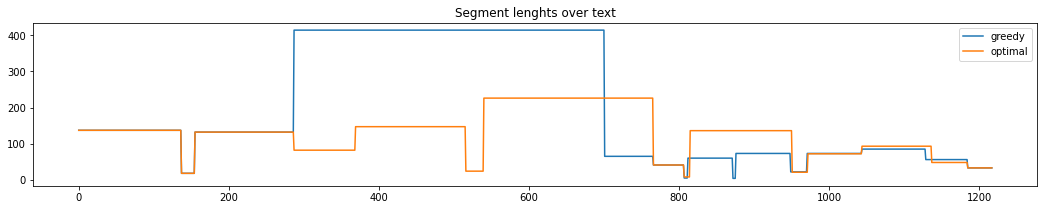

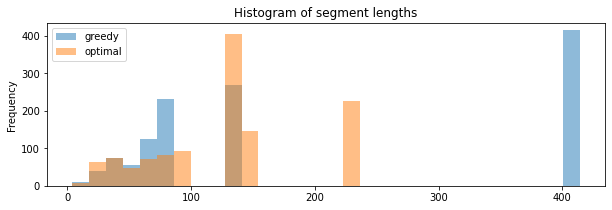

In [12]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)
new_length = len(sentenced_text)**0.6
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
#penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [13]:
for i in range(len(segmented_text)):
  print(segmented_text[i])
  

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

In [14]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.').rstrip('?'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))
print(first_sentence)
1

Welcome to the huberman Lab podcast. 
<class 'str'>
137
So it's a very logical system. 
<class 'str'>
18
Meaning it's Peaks and it's valleys are more like Smooth it out and that glucose is sequestered. 
<class 'str'>
132
Fructose, of course, is found in fruit. 
<class 'str'>
82
That regulates our appetite for sugar. 
<class 'str'>
147
And as I described this experiment, I think you will come to understand the power of these circuits. 
<class 'str'>
24
Now. 
<class 'str'>
226
What they do is they have people and He studies were done in people and just multi dextrin, which increases blood glucose doesn't have much flavor, but even if it Does have a little bit of subtle flavor. 
<class 'str'>
41
So, that's not really a fair experiment or it's not our natural world experiment. 
<class 'str'>
8
Do not think that they are not dangerous. 
<class 'str'>
136
Many of them have reported back that they actually feel as if their sugar Cravings are reduced. 
<class 'str'>
21
When we ingest sugary sw

1

In [15]:
print(sentenced_text)

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

### 處理輸入

In [16]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [17]:
print(podcast_test)

["Welcome to the huberman Lab podcast. We discussed science science basic tools for everyday life. I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. Today. We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. And its various forms is strongly reinforcing. Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. Incidentally sweet taste also make us want to eat more of other substances as well. You may

# Headline generator

In [18]:
! pip install transformers datasets

     |████████████████████████████████| 4.2 MB 9.2 MB/s 
     |████████████████████████████████| 342 kB 46.1 MB/s 
     |████████████████████████████████| 6.6 MB 40.8 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 596 kB 43.9 MB/s 
     |████████████████████████████████| 1.1 MB 34.9 MB/s 
     |████████████████████████████████| 212 kB 41.9 MB/s 
     |████████████████████████████████| 136 kB 42.0 MB/s 
     |████████████████████████████████| 127 kB 45.7 MB/s 
     |████████████████████████████████| 144 kB 45.0 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 271 kB 43.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
E

In [19]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.9 MB/s 


In [20]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [21]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [22]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [23]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)
Token indices sequence length is longer than the specified maximum sequence length for this model (2871 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [24]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'The Brain and the Brain - The Science and Science Podcast'}
<class 'dict'>
{'generated_text': 'Type 1 Diabetes - How to Clamp Blood Glucose Levels'}
<class 'dict'>
{'generated_text': 'The Importance of Glucose in the Nervous System'}
<class 'dict'>
{'generated_text': 'Is Fructose a Good Thing for Weight Loss?'}
<class 'dict'>
{'generated_text': 'Dopamine and the Pleasure Pain - The Secret of the Mood and'}
<class 'dict'>
{'generated_text': 'The Effect of the Sense of Sweetness in Foods'}
<class 'dict'>
{'generated_text': 'The Effects of Sugary Foods on Your Blood Sugar'}
<class 'dict'>
{'generated_text': 'Is There a Conversion of Artificial Sweeteners?'}
<class 'dict'>
{'generated_text': 'Is This a Fair Experiment?'}
<class 'dict'>
{'generated_text': 'ADHD and the Effects of Sugar Consumption'}
<class 'dict'>
{'generated_text': 'Reduce Sugar Cravings - Is There a Way to Reduce Sugar Crav'}
<class 'dict'>
{'generated_text': 'How Lemon Juice and Lime Juice Can Decreas

In [25]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Brain and the Brain', '-', 'The Science and Science Podcast']
['The Brain and the Brain', '-', 'The Science and Science Podcast']
<class 'str'>
['Type 1 Diabetes', '-', 'How to Clamp Blood Glucose Levels']
['Type 1 Diabetes', '-', 'How to Clamp Blood Glucose Levels']
<class 'str'>
['The Importance of Glucose in the Nervous System']
['The Importance of Glucose in the Nervous System']
<class 'str'>
['Is Fructose a Good Thing for Weight Loss?']
['Is Fructose a Good Thing for Weight Loss?']
<class 'str'>
['Dopamine and the Pleasure Pain', '-', 'The Secret of the Mood and']
['Dopamine and the Pleasure Pain', '-', 'The Secret of the Mood and']
<class 'str'>
['The Effect of the Sense of Sweetness in Foods']
['The Effect of the Sense of Sweetness in Foods']
<class 'str'>
['The Effects of Sugary Foods on Your Blood Sugar']
['The Effects of Sugary Foods on Your Blood Sugar']
<class 'str'>
['Is There a Conversion of Artificial Sweeteners?']
['Is There a Conversion of Artificial Sweeteners?'

In [26]:
for headline_string in headlines_string:
  print(headline_string)

 The Brain and the Brain - The Science and Science Podcast
 Type 1 Diabetes - How to Clamp Blood Glucose Levels
 The Importance of Glucose in the Nervous System
 Is Fructose a Good Thing for Weight Loss?
 Dopamine and the Pleasure Pain - The Secret of the Mood and
 The Effect of the Sense of Sweetness in Foods
 The Effects of Sugary Foods on Your Blood Sugar
 Is There a Conversion of Artificial Sweeteners?
 Is This a Fair Experiment?
 ADHD and the Effects of Sugar Consumption
 Reduce Sugar Cravings - Is There a Way to Reduce Sugar Crav
 How Lemon Juice and Lime Juice Can Decrease Blood Glucose
 The Best Tool For Controlling Blood Glucose
 The Importance of Sleep in the Brain and Body
 The Government Lab Podcast - Part 2


In [27]:
print(headlines_string)
1

[' The Brain and the Brain - The Science and Science Podcast', ' Type 1 Diabetes - How to Clamp Blood Glucose Levels', ' The Importance of Glucose in the Nervous System', ' Is Fructose a Good Thing for Weight Loss?', ' Dopamine and the Pleasure Pain - The Secret of the Mood and', ' The Effect of the Sense of Sweetness in Foods', ' The Effects of Sugary Foods on Your Blood Sugar', ' Is There a Conversion of Artificial Sweeteners?', ' Is This a Fair Experiment?', ' ADHD and the Effects of Sugar Consumption', ' Reduce Sugar Cravings - Is There a Way to Reduce Sugar Crav', ' How Lemon Juice and Lime Juice Can Decrease Blood Glucose', ' The Best Tool For Controlling Blood Glucose', ' The Importance of Sleep in the Brain and Body', ' The Government Lab Podcast - Part 2']


1

In [28]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']


# 去掉廣告

In [29]:
!pip install -U scikit-learn
!pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 8.4 MB/s 
     |████████████████████████████████| 749 kB 44.6 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 使用停使用停用詞(NLTK)

In [31]:
# 下面的代碼是使用nltk從句子中去除停用詞 
# 導入包 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("stopwords")
#set(stopwords.words('english')) 
# 例句 
#text = """He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had indeed the vaguest idea where the wood and river in question were.""" 
# 停用詞集合 
stop_words = set(stopwords.words('english')) 
# 分詞 
nltk.download('punkt')
result_nltk = []
for sent in podcast_test:
  word_tokens = word_tokenize(sent) 
  filtered_sentence = [] 
  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
  result_nltk.append(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [32]:
print(len(result_nltk))
print(result_nltk)

15
["Welcome huberman Lab podcast . We discussed science science basic tools everyday life . I 'm Andrew huberman , I 'm professor neurobiology Ophthalmology Stanford school medicine . Today . We going discuss sugar particular nervous system , regulate , sugar intake seeking sugar . We 're also going discuss sugar regulates nervous system 'll soon , learn sugar really impacts brain body two main mechanism . One mechanisms based Sweet Taste sugar rewarding , even 're much sweet tooth , I confess . I 'm people enjoy sweet taste bitter taste , Sweet Taste sugar . And various forms strongly reinforcing . Meaning triggers activation neurons nerve cells brain body make us want consume sweet substance . Incidentally sweet taste also make us want eat substances well . You may familiar phenomenon . Now sugar also triggers mechanisms brain body based nutritive content independent . Its sweetness . What means actual caloric content way Sugar interacts nervous system subconscious level without awa

In [33]:
vectorizer_nltk = CountVectorizer()
transformer_nltk = TfidfTransformer()
tfidf_nltk = transformer_nltk.fit_transform(vectorizer_nltk.fit_transform(result_nltk))
feature_name_nltk = vectorizer_nltk.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
print(len(feature_name_nltk))
print(feature_name_nltk)

2490
['10', '100', '11', '12', '15', '17th', '18th', '1st', '20', '2012', '30', '3s', '45', '46', '50', '55', '70', '750', '80', '88th', '90', 'ability', 'able', 'absence', 'absolute', 'absolutely', 'abundance', 'abundant', 'accelerator', 'accelerators', 'accept', 'access', 'accident', 'accounting', 'acetylcholine', 'achieve', 'achieving', 'acid', 'acidic', 'acidity', 'acids', 'acknowledge', 'across', 'acting', 'action', 'actionable', 'actions', 'activate', 'activating', 'activation', 'active', 'activities', 'activity', 'actual', 'actually', 'adapted', 'addiction', 'addictive', 'addition', 'additional', 'adhd', 'adjust', 'adjusted', 'adjusting', 'adjustment', 'adrenaline', 'adult', 'adults', 'advanced', 'advantage', 'advantageous', 'affect', 'after', 'ag1', 'again', 'agitated', 'agree', 'agrees', 'ahead', 'aiming', 'alert', 'alkaline', 'alkalinity', 'all', 'allergy', 'allow', 'allowing', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'alter', 'although', 'always', 'am', 'amaz

In [35]:
for i in range(len(feature_name_nltk)):
  try:
    s = model.similarity('sponsor',feature_name_nltk[i])
    print(feature_name_nltk[i],end=" ")
    print(s)
  except:
    pass
  

ability 0.1410298
able 0.098063596
absence -0.08160388
absolute -0.049078025
absolutely 0.005259383
abundance -0.15708141
abundant -0.074165806
accelerator 0.13440543
accelerators 0.038917348
accept 0.12263503
access 0.24805939
accident 0.15202726
accounting 0.16869497
acetylcholine -0.005810202
achieve 0.1160639
achieving 0.24037115
acid -0.051458124
acidic -0.023393577
acidity 0.029483162
acids -0.018143391
acknowledge 0.12389293
across 0.053228967
acting 0.13436063
action 0.1615972
actions 0.17880923
activate 0.085206784
activating -0.06768806
activation 0.06782119
active 0.27814016
activities 0.2867408
activity 0.11584351
actual 0.057923596
actually 0.039647013
adapted -0.19280486
addiction 0.13959748
addictive 0.115347035
addition 0.25858405
additional 0.25036666
adhd 0.13261881
adjust 0.15191376
adjusted 0.105169326
adjusting 0.15035208
adjustment 0.20267773
adrenaline 0.13720372
adult 0.12463905
adults 0.13867365
advanced 0.035247874
advantage 0.07050476
advantageous 0.11189225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


because 0.1268937
become 0.19010542
becomes -0.07904359
becoming 0.24205185
been 0.049444314
bees 0.07068765
before 0.1449743
begin 0.06341945
beginning -0.010585757
behavior 0.029820783
behavioral 0.0036216183
behaviors 0.1038139
beings -0.051147584
believe 0.011893862
believer 0.091306604
beneficial 0.15046147
benefit 0.25836873
besides 0.0916347
best 0.07540655
better 0.022298437
beverage 0.23026799
beverages 0.18551828
beyond -0.005420958
big 0.07373412
biological 0.005548263
biology -0.040206578
bird 0.023834955
birth 0.071327545
bit -0.09938719
bite 0.09339237
bitter -0.029761763
blade -0.13125148
blind 0.009774505
block 0.071706355
blocked 0.24724211
blocks 0.08346541
blood 0.0021153323
bloodstream 0.036348037
blount 0.06022495
blunt 0.029728737
blurred 0.010028416
board 0.23531564
bodies 0.13728863
body 0.10559064
book -0.06629855
books -0.07501817
both 0.0960471
bottle 0.03461317
bout 0.12239392
bowl 0.18102422
brain 0.044532914
brains -0.00795468
brakes 0.1525578
brands 0.328

In [36]:
sponsor_n =0
for i in range(len(feature_name_nltk)):
  if feature_name_nltk[i]=='sponsor':
    sponsor_n =i
    print(i)

2083


In [37]:
sponsor_n2 =0
for i in range(len(feature_name_nltk)):
  try:
    s1 = model.similarity('sponsor',feature_name_nltk[i])
    s2 = model.similarity('sponsored',feature_name_nltk[i])
    if s1>0.6 or s2>0.6:
      print("s1",end=': ')
      print(s1,end=', ')
      print("s2",end=': ')
      print(s2,end=', \n')
      sponsor_n2 =i
      print(i)
  except:
    pass
  
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """


s1: 1.0000001, s2: 0.34285876, 
2083


In [38]:
# 找出含sponsor的段落內的keyword和其tfidf
from nltk.util import pr
print(type(tfidf_nltk))
keyword_segment = []
tfidf_segment = []
#print(tfidf_nltk)
#print(tfidf_nltk.toarray())
array_tfidf_nltk = tfidf_nltk.toarray()
#print(array_tfidf_nltk)
#print(array_tfidf_nltk[0])
for i in range(len(array_tfidf_nltk)):
  if(array_tfidf_nltk[i][sponsor_n2]>0):
    print(i)
    for j in range(len(array_tfidf_nltk[i])):
      if(array_tfidf_nltk[i][j]>0):
        keyword_segment.append(feature_name_nltk[j])
        tfidf_segment.append(array_tfidf_nltk[i][j])
        print(feature_name_nltk[j]," ",array_tfidf_nltk[i][j])

<class 'scipy.sparse.csr.csr_matrix'>
0
10   0.01324684266566087
17th   0.04466344347557358
18th   0.04466344347557358
1st   0.02233172173778679
20   0.01730510579132779
2012   0.02233172173778679
ability   0.02284868424583358
accept   0.02233172173778679
access   0.03461021158265558
accounting   0.02233172173778679
achieve   0.02233172173778679
achieving   0.02233172173778679
acknowledge   0.01939133990358129
actionable   0.01939133990358129
activation   0.01939133990358129
actual   0.01730510579132779
actually   0.008220226719201869
addition   0.01324684266566087
ag1   0.02233172173778679
agitated   0.01939133990358129
agree   0.06699516521336035
agrees   0.01939133990358129
alert   0.01939133990358129
all   0.03461021158265558
allow   0.03974052799698261
allowing   0.01939133990358129
also   0.09042249391122055
analyzes   0.02233172173778679
and   0.10686294734962429
andrew   0.01939133990358129
announce   0.02233172173778679
anymore   0.02233172173778679
anyone   0.0223317217377867

In [39]:
print(keyword_segment)
print(tfidf_segment)

['10', '17th', '18th', '1st', '20', '2012', 'ability', 'accept', 'access', 'accounting', 'achieve', 'achieving', 'acknowledge', 'actionable', 'activation', 'actual', 'actually', 'addition', 'ag1', 'agitated', 'agree', 'agrees', 'alert', 'all', 'allow', 'allowing', 'also', 'analyzes', 'and', 'andrew', 'announce', 'anymore', 'anyone', 'anytime', 'arcuate', 'area', 'areas', 'around', 'artist', 'asian', 'aspects', 'associate', 'ate', 'athletic', 'avoid', 'avoidance', 'aware', 'awareness', 'away', 'back', 'bad', 'balance', 'based', 'basic', 'basically', 'been', 'bees', 'before', 'begin', 'behaviors', 'believe', 'believer', 'best', 'better', 'beyond', 'biloba', 'biological', 'bit', 'bitter', 'blood', 'body', 'both', 'brain', 'brains', 'breathing', 'bring', 'brought', 'bunch', 'burn', 'burning', 'but', 'calcium', 'called', 'calling', 'caloric', 'calories', 'cam', 'cardiovascular', 'case', 'cases', 'cast', 'cells', 'certain', 'certainly', 'changer', 'check', 'checkout', 'chemistry', 'choices',

In [40]:
# 把含sponsor的後lenth句都作為極有可能是sponaor的區塊
length = 10
sponsor_block = []
for i in range(len(sentenced_text)):
  ws = word_tokenize(sentenced_text[i])
  for w in ws:
    if("sponsor" == w or "sponsors" == w or "Sponsor" == w or "Sponsors" == w or feature_name_nltk[sponsor_n2]==w):
      sponsor_block.append(sentenced_text[i])
      for h in range(length):
        if((i+h)<len(sentenced_text)): sponsor_block.append(sentenced_text[i+h])
        
      
sponsor_block = " ".join(sponsor_block)
print(sponsor_block)

I'd like to thank the sponsors of today's podcast.  I'd like to thank the sponsors of today's podcast.  Our first sponsor is thesis thesis makes what are called nootropics, which means it's smart.  Drugs, be honest.  I'm not a fan of the term nootropics.  I don't believe in smart drugs.  In the sense that I don't believe that there's any one substance, or collection of substances that can make us smarter.  I do believe based on science.  However, that there are particular, neural circuits and brain functions that allow it to be more focused, more alert accept creativity, be more motivated States.  And so the idea of a nootropic that's just going to make us smarter all-around fail, to acknowledge that smarter is many things, right?  If you're an artist or a musician, you're doing math, you're doing accounting a different part of the day you need to be Create a bees are all different.  Our first sponsor is thesis thesis makes what are called nootropics, which means it's smart.  Our first

In [41]:
# 把sponsor block內的keyword和tdidf記下來
sponsor_word = word_tokenize(sponsor_block)
print(sponsor_word)

keyword_sponsor=[]
tfidf_sponsor=[]
for i in range(len(sponsor_word)):
  if(sponsor_word[i] in keyword_segment and sponsor_word[i] not in keyword_sponsor):
    keyword_sponsor.append(sponsor_word[i])
    tfidf_sponsor.append(tfidf_segment[keyword_segment.index(sponsor_word[i])])
print(len(keyword_sponsor))
print(len(tfidf_sponsor))
n = len(keyword_sponsor)
for i in range(n):
  for j in range(0,n-i-1):
    
    if(tfidf_sponsor[j]>tfidf_sponsor[j+1]):
      tfidf_sponsor[j], tfidf_sponsor[j+1] =  tfidf_sponsor[j+1], tfidf_sponsor[j]
      keyword_sponsor[j], keyword_sponsor[j+1] =  keyword_sponsor[j+1], keyword_sponsor[j]
for i in range(0,n):
  print(keyword_sponsor[i]," ",tfidf_sponsor[i])

['I', "'d", 'like', 'to', 'thank', 'the', 'sponsors', 'of', 'today', "'s", 'podcast', '.', 'I', "'d", 'like', 'to', 'thank', 'the', 'sponsors', 'of', 'today', "'s", 'podcast', '.', 'Our', 'first', 'sponsor', 'is', 'thesis', 'thesis', 'makes', 'what', 'are', 'called', 'nootropics', ',', 'which', 'means', 'it', "'s", 'smart', '.', 'Drugs', ',', 'be', 'honest', '.', 'I', "'m", 'not', 'a', 'fan', 'of', 'the', 'term', 'nootropics', '.', 'I', 'do', "n't", 'believe', 'in', 'smart', 'drugs', '.', 'In', 'the', 'sense', 'that', 'I', 'do', "n't", 'believe', 'that', 'there', "'s", 'any', 'one', 'substance', ',', 'or', 'collection', 'of', 'substances', 'that', 'can', 'make', 'us', 'smarter', '.', 'I', 'do', 'believe', 'based', 'on', 'science', '.', 'However', ',', 'that', 'there', 'are', 'particular', ',', 'neural', 'circuits', 'and', 'brain', 'functions', 'that', 'allow', 'it', 'to', 'be', 'more', 'focused', ',', 'more', 'alert', 'accept', 'creativity', ',', 'be', 'more', 'motivated', 'States', '.

## 篩選出名詞和形容詞

In [42]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.pos_tag(sent)
    return sent
part = preprocess(keyword_sponsor)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [43]:
select_word = []
#part = part.reverse()
for i in range(len(part)):
  if(part[i][1]=='NN' or part[i][1]=='NNS' or part[i][1]=='JJ'or part[i][1]=='JJR'):
    select_word.append(part[i][0])

In [44]:
select_word

['sense',
 'addition',
 'level',
 'idea',
 'please',
 'distinct',
 'sponsors',
 'fail',
 'acknowledge',
 'circuits',
 'fan',
 'collection',
 'creativity',
 'artist',
 'musician',
 'math',
 'accounting',
 'bees',
 'fees',
 'day',
 'substance',
 'neural',
 'content',
 'term',
 'drugs',
 'substances',
 'functions',
 'allow',
 'part',
 'way',
 'many',
 'smart',
 'nootropic',
 'need',
 'things',
 'particular',
 'thesis',
 'smarter',
 'cover',
 'podcast',
 'different',
 'science',
 'today',
 'nootropics',
 'brain']

## 去掉sponsor

In [45]:
for i in range(len(sentenced_text)):
  matches = [a for a in select_word if a in sentenced_text[i]]
  #print(all_sentence[i])
  print(matches)

['podcast']
['day', 'science']
[]
['day']
['part', 'particular']
['brain']
[]
[]
[]
['substance', 'brain']
['substance', 'substances']
[]
['content', 'brain']
[]
['level', 'day', 'content', 'way', 'today']
['term', 'brain']
[]
['part', 'particular', 'brain']
[]
['day', 'today']
[]
[]
['allow', 'brain']
['please']
[]
[]
[]
['part', 'science']
['cover', 'podcast']
['distinct', 'cover', 'podcast']
[]
[]
[]
[]
['podcast']
['part', 'science']
['sponsors', 'day', 'podcast', 'today']
['smart', 'nootropic', 'thesis', 'nootropics']
[]
['fan', 'term', 'nootropic', 'nootropics']
['drugs', 'smart']
['sense', 'collection', 'substance', 'substances', 'smart', 'smarter']
['science']
['circuits', 'creativity', 'neural', 'functions', 'allow', 'part', 'particular', 'brain']
['idea', 'fail', 'acknowledge', 'many', 'smart', 'nootropic', 'things', 'smarter']
['artist', 'musician', 'math', 'accounting', 'bees', 'day', 'part', 'need', 'different']
['fees']
['nootropic', 'nootropics']
[]
['things', 'podcast']

In [46]:
num = 5
match_num=1
before_flag = [0]*num
is_sponsor = []
for i in range(len(sentenced_text)):
  if("sponsor" in sentenced_text[i]):
    
    for j in range(i,len(sentenced_text)):
      matches = [a for a in select_word if a in sentenced_text[j]]
      
      for f in range(num-1,0,-1):
        before_flag[f] = before_flag[f-1]
      if(len(matches)>=match_num or i==j): before_flag[0] = 1
      else: before_flag[0] = 0
      print(before_flag)
      flag=0
      for f in range(num):
        if(before_flag[f]==1): 
          flag=1
          break
      if(flag==1):
        if((j-num+1)>=i): is_sponsor.append(sentenced_text[j-num+1])
        
      else:
        is_sponsor.append("----------------------------------------------------------------")
        break
    break

[1, 0, 0, 0, 0]
[1, 1, 0, 0, 0]
[0, 1, 1, 0, 0]
[1, 0, 1, 1, 0]
[1, 1, 0, 1, 1]
[1, 1, 1, 0, 1]
[1, 1, 1, 1, 0]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[0, 1, 1, 1, 1]
[1, 0, 1, 1, 1]
[1, 1, 0, 1, 1]
[1, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[1, 0, 1, 1, 1]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[0, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[1, 0, 0, 1, 0]
[0, 1, 0, 0, 1]
[0, 0, 1, 0, 0]
[0, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[0, 1, 0, 0, 0]
[1, 0, 1, 0, 0]
[0, 1, 0, 1, 0]
[1, 0, 1, 0, 1]
[0, 1, 0, 1, 0]
[1, 0, 1, 0, 1]
[1, 1, 0, 1, 0]
[0, 1, 1, 0, 1]
[0, 0, 1, 1, 0]
[1, 0, 0, 1, 1]
[1, 1, 0, 0, 1]
[0, 1, 1, 0, 0]
[0, 0, 1, 1, 0]
[0, 0, 0, 1, 1]
[1, 0, 0, 0, 1]
[1, 1, 0, 0, 0]
[0, 1, 1, 0, 0]
[1, 0, 1, 1, 0]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[1, 0, 0, 1, 0]
[0, 1, 0, 0, 1]
[1, 0, 1, 0, 0]
[1, 1, 0, 1, 0]
[0, 1, 1, 0, 1]
[1, 0, 1, 1, 0]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 0]


In [47]:
for sent in is_sponsor: 
  print(sent)

I'd like to thank the sponsors of today's podcast. 
Our first sponsor is thesis thesis makes what are called nootropics, which means it's smart. 
Drugs, be honest. 
I'm not a fan of the term nootropics. 
I don't believe in smart drugs. 
In the sense that I don't believe that there's any one substance, or collection of substances that can make us smarter. 
I do believe based on science. 
However, that there are particular, neural circuits and brain functions that allow it to be more focused, more alert accept creativity, be more motivated States. 
And so the idea of a nootropic that's just going to make us smarter all-around fail, to acknowledge that smarter is many things, right? 
If you're an artist or a musician, you're doing math, you're doing accounting a different part of the day you need to be Create a bees are all different. 
Brain processing fees understands this. 
And as far as I know that the first nootropics company to create Target in nootropics for specific outcomes. 
The 

In [48]:
del_sponsor_sentence = []
for i in range(len(sentenced_text)):
  if (sentenced_text[i] not in is_sponsor):
    del_sponsor_sentence.append(sentenced_text[i])
for sent in del_sponsor_sentence: 
  print(sent)

Welcome to the huberman Lab podcast. 
We discussed science science basic tools for everyday life. 
I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. 
Today. 
We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. 
We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. 
One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. 
I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. 
And its various forms is strongly reinforcing. 
Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. 
Incidentally sweet taste also make us want to eat more of other substances as well.

# 重新來分段一次

69.07928421282476
penalty 56.68
1163 sentences, 15 segments, avg 77.53 sentences per segment
optimal score 38561.68, greedy score 38522.14
[38561.67629224918, 38522.135332478254]
(38561.67629224918, 38522.135332478254)
ratio of scores 1.0010


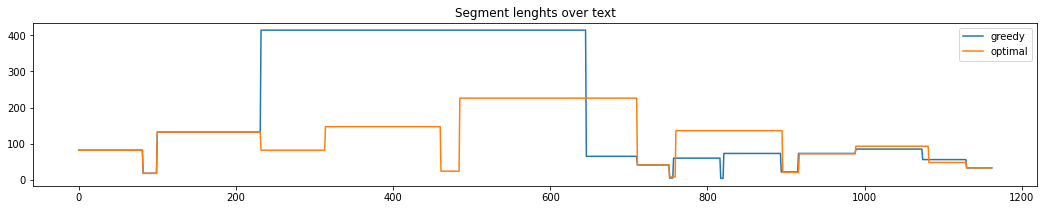

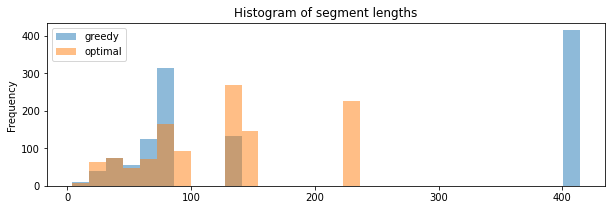

In [49]:
strs = " "
for i in range(len(del_sponsor_sentence)):
  if(del_sponsor_sentence[i] != " "):
    strs =del_sponsor_sentence[i]
  if(i+1<len(del_sponsor_sentence)):
    if(strs == del_sponsor_sentence[i+1]):
      del_sponsor_sentence[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(del_sponsor_sentence).dot(wrdvecs)
new_length = len(del_sponsor_sentence)**0.6
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(del_sponsor_sentence, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(del_sponsor_sentence), len(segmented_text), len(del_sponsor_sentence) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(del_sponsor_sentence, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [50]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

In [51]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [52]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

Ignoring args : (5, 150)


In [53]:
for headline in headlines:
  print(headline)
  

{'generated_text': 'The Brain Body Contract - The Huberman Lab Podcast'}
{'generated_text': 'Type 1 Diabetes - How to Clamp Blood Glucose Levels'}
{'generated_text': 'The Importance of Glucose in the Nervous System'}
{'generated_text': 'Is Fructose a Good Thing for Weight Loss?'}
{'generated_text': 'Dopamine and the Pleasure Pain - The Secret of the Mood and'}
{'generated_text': 'The Effect of the Sense of Sweetness in Foods'}
{'generated_text': 'The Effects of Sugary Foods on Your Blood Sugar'}
{'generated_text': 'Is There a Conversion of Artificial Sweeteners?'}
{'generated_text': 'Is This a Fair Experiment?'}
{'generated_text': 'ADHD and the Effects of Sugar Consumption'}
{'generated_text': 'Reduce Sugar Cravings - Is There a Way to Reduce Sugar Crav'}
{'generated_text': 'How Lemon Juice and Lime Juice Can Decrease Blood Glucose'}
{'generated_text': 'The Best Tool For Controlling Blood Glucose'}
{'generated_text': 'The Importance of Sleep in the Brain and Body'}
{'generated_text': '

In [54]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Brain Body Contract', '-', 'The Huberman Lab Podcast']
['The Brain Body Contract', '-', 'The Huberman Lab Podcast']
<class 'str'>
['Type 1 Diabetes', '-', 'How to Clamp Blood Glucose Levels']
['Type 1 Diabetes', '-', 'How to Clamp Blood Glucose Levels']
<class 'str'>
['The Importance of Glucose in the Nervous System']
['The Importance of Glucose in the Nervous System']
<class 'str'>
['Is Fructose a Good Thing for Weight Loss?']
['Is Fructose a Good Thing for Weight Loss?']
<class 'str'>
['Dopamine and the Pleasure Pain', '-', 'The Secret of the Mood and']
['Dopamine and the Pleasure Pain', '-', 'The Secret of the Mood and']
<class 'str'>
['The Effect of the Sense of Sweetness in Foods']
['The Effect of the Sense of Sweetness in Foods']
<class 'str'>
['The Effects of Sugary Foods on Your Blood Sugar']
['The Effects of Sugary Foods on Your Blood Sugar']
<class 'str'>
['Is There a Conversion of Artificial Sweeteners?']
['Is There a Conversion of Artificial Sweeteners?']
<class 'str'

In [55]:
for headline_string in headlines_string:
  print(headline_string)

 The Brain Body Contract - The Huberman Lab Podcast
 Type 1 Diabetes - How to Clamp Blood Glucose Levels
 The Importance of Glucose in the Nervous System
 Is Fructose a Good Thing for Weight Loss?
 Dopamine and the Pleasure Pain - The Secret of the Mood and
 The Effect of the Sense of Sweetness in Foods
 The Effects of Sugary Foods on Your Blood Sugar
 Is There a Conversion of Artificial Sweeteners?
 Is This a Fair Experiment?
 ADHD and the Effects of Sugar Consumption
 Reduce Sugar Cravings - Is There a Way to Reduce Sugar Crav
 How Lemon Juice and Lime Juice Can Decrease Blood Glucose
 The Best Tool For Controlling Blood Glucose
 The Importance of Sleep in the Brain and Body
 The Government Lab Podcast - Part 2


In [56]:
len(headlines_string)

15

In [57]:
print(headlines_string)
3

[' The Brain Body Contract - The Huberman Lab Podcast', ' Type 1 Diabetes - How to Clamp Blood Glucose Levels', ' The Importance of Glucose in the Nervous System', ' Is Fructose a Good Thing for Weight Loss?', ' Dopamine and the Pleasure Pain - The Secret of the Mood and', ' The Effect of the Sense of Sweetness in Foods', ' The Effects of Sugary Foods on Your Blood Sugar', ' Is There a Conversion of Artificial Sweeteners?', ' Is This a Fair Experiment?', ' ADHD and the Effects of Sugar Consumption', ' Reduce Sugar Cravings - Is There a Way to Reduce Sugar Crav', ' How Lemon Juice and Lime Juice Can Decrease Blood Glucose', ' The Best Tool For Controlling Blood Glucose', ' The Importance of Sleep in the Brain and Body', ' The Government Lab Podcast - Part 2']


3

In [58]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.').rstrip('?'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))

Welcome to the huberman Lab podcast. 
<class 'str'>
82
So it's a very logical system. 
<class 'str'>
18
Meaning it's Peaks and it's valleys are more like Smooth it out and that glucose is sequestered. 
<class 'str'>
132
Fructose, of course, is found in fruit. 
<class 'str'>
82
That regulates our appetite for sugar. 
<class 'str'>
147
And as I described this experiment, I think you will come to understand the power of these circuits. 
<class 'str'>
24
Now. 
<class 'str'>
226
What they do is they have people and He studies were done in people and just multi dextrin, which increases blood glucose doesn't have much flavor, but even if it Does have a little bit of subtle flavor. 
<class 'str'>
41
So, that's not really a fair experiment or it's not our natural world experiment. 
<class 'str'>
8
Do not think that they are not dangerous. 
<class 'str'>
136
Many of them have reported back that they actually feel as if their sugar Cravings are reduced. 
<class 'str'>
21
When we ingest sugary swe

In [59]:
print(first_sentence)
print(len((first_sentence)))

['Welcome to the huberman Lab podcast', "So it's a very logical system", "Meaning it's Peaks and it's valleys are more like Smooth it out and that glucose is sequestered", 'Fructose, of course, is found in fruit', 'That regulates our appetite for sugar', 'And as I described this experiment, I think you will come to understand the power of these circuits', 'Now', "What they do is they have people and He studies were done in people and just multi dextrin, which increases blood glucose doesn't have much flavor, but even if it Does have a little bit of subtle flavor", "So, that's not really a fair experiment or it's not our natural world experiment", 'Do not think that they are not dangerous', 'Many of them have reported back that they actually feel as if their sugar Cravings are reduced', 'When we ingest sugary sweet Foods or even just an abundance of carbohydrate foods and their huge number of these things', "There's some debate out there", 'We have a newsletter the brought tools and how